# Project Introduction

In this project, I perform an in-depth evaluation of multiple classification methods on two different datasets: one biomedical (breast cancer gene expression) and one clinical (heart disease data). The goal is to compare model performance across datasets using a consistent pipeline and determine which models are most effective depending on dataset characteristics.

This aligns with Option 2, Example 3 of the course project guidelines, where we evaluate classifiers on diverse datasets and analyze correlations among model predictions.

In [2]:
!pip install xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.decomposition import PCA

# Dataset Overview

We work with two datasets:
- **Cancer Dataset:** High-dimensional gene expression data from 1,616 patients across 12,750 genes. Each sample is labeled for metastasis (0 = No, 1 = Yes).
- **Heart Disease Dataset:** 1,025 patient records with 14 attributes related to cardiovascular health. The target is presence of heart disease (1) or not (0).

Initial visualizations (class distributions and PCA projections) are used to understand data separability and guide preprocessing.

In [3]:
df = pd.read_csv('ACES.zip', index_col=0)

# Column 0 = metastasis label, Column 1 = subtype, rest are gene expressions
y_cancer = df.iloc[:, 0].values
subtypes = df.iloc[:, 1].values
X_cancer = df.iloc[:, 2:].values

print("Cancer Dataset Loaded")
print("Shape of X:", X_cancer.shape)
print("Shape of y:", y_cancer.shape)

Cancer Dataset Loaded
Shape of X: (1616, 12750)
Shape of y: (1616,)


Cancer dataset shape: (1616, 12750)


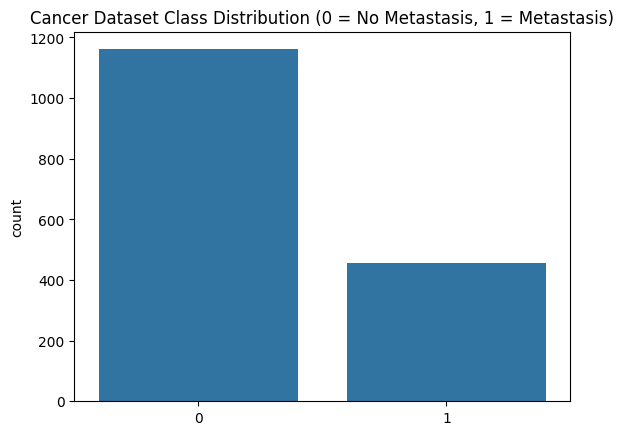

In [4]:
# Check dataset shape
print("Cancer dataset shape:", X_cancer.shape)
sns.countplot(x=y_cancer)
plt.title("Cancer Dataset Class Distribution (0 = No Metastasis, 1 = Metastasis)")
plt.show()

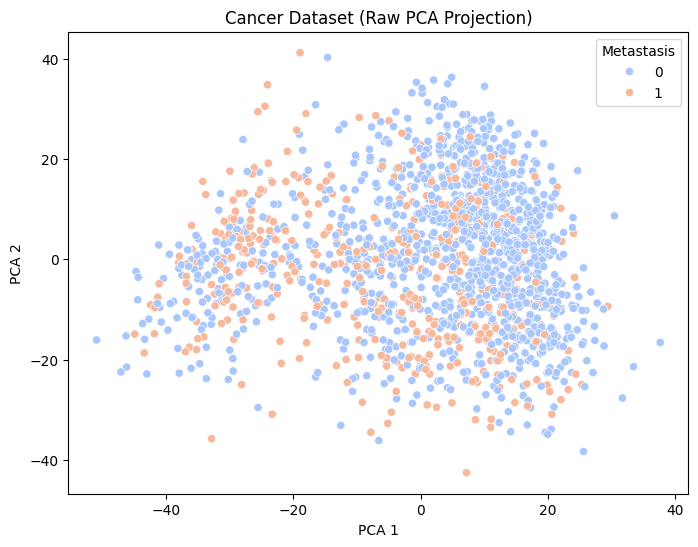

In [5]:
# Visualize using PCA
pca_raw = PCA(n_components=2)
Xc_raw_pca = pca_raw.fit_transform(X_cancer)

plt.figure(figsize=(8,6))
sns.scatterplot(x=Xc_raw_pca[:,0], y=Xc_raw_pca[:,1], hue=y_cancer, palette='coolwarm')
plt.title("Cancer Dataset (Raw PCA Projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Metastasis")
plt.show()

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

models = {
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}

scaler_cancer = StandardScaler()
X_cancer_scaled = scaler_cancer.fit_transform(X_cancer)

pca_reduced = PCA(n_components=300)
X_cancer_reduced = pca_reduced.fit_transform(X_cancer_scaled)

print("Cross-Validation Results (Cancer Dataset - 300 PCA Components):")
for name, model in models.items():
    scores = cross_val_score(model, X_cancer_reduced, y_cancer, cv=5, scoring='accuracy')
    print(f"{name}: Mean Accuracy = {scores.mean():.4f}, Std = {scores.std():.4f}")

Cross-Validation Results (Cancer Dataset - 300 PCA Components):
KNN: Mean Accuracy = 0.7185, Std = 0.0211
Decision Tree: Mean Accuracy = 0.6337, Std = 0.0250
SVM: Mean Accuracy = 0.7203, Std = 0.0147
XGBoost: Mean Accuracy = 0.7092, Std = 0.0098


After scaling the gene expression data, I applied Principal Component Analysis (PCA) to reduce the feature set from over 12,000 genes to just 300 principal components. This reduction helped retain most of the important variance while significantly improving training speed and reducing overfitting risk.
This allowed me to compare models under consistent conditions, reducing the bias of random train/test splits (following Dr. Ruan’s feedback).
The SVM and KNN models performed best in this context, both achieving over 71% accuracy on average.

In [7]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import roc_auc_score, classification_report

xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
y_prob_cv = cross_val_predict(xgb_model, X_cancer_reduced, y_cancer, cv=5, method='predict_proba')[:, 1]

auc = roc_auc_score(y_cancer, y_prob_cv)
print(f"\nAUC Score (XGBoost): {auc:.4f}")

for threshold in [0.3, 0.5, 0.7]:
    y_pred_thresh = (y_prob_cv >= threshold).astype(int)
    print(f"\nThreshold: {threshold}")
    print(classification_report(y_cancer, y_pred_thresh, target_names=['No Metastasis', 'Metastasis']))


AUC Score (XGBoost): 0.6608

Threshold: 0.3
               precision    recall  f1-score   support

No Metastasis       0.76      0.86      0.80      1161
   Metastasis       0.46      0.31      0.37       455

     accuracy                           0.70      1616
    macro avg       0.61      0.58      0.59      1616
 weighted avg       0.67      0.70      0.68      1616


Threshold: 0.5
               precision    recall  f1-score   support

No Metastasis       0.74      0.92      0.82      1161
   Metastasis       0.45      0.16      0.24       455

     accuracy                           0.71      1616
    macro avg       0.60      0.54      0.53      1616
 weighted avg       0.66      0.71      0.66      1616


Threshold: 0.7
               precision    recall  f1-score   support

No Metastasis       0.73      0.97      0.83      1161
   Metastasis       0.50      0.08      0.14       455

     accuracy                           0.72      1616
    macro avg       0.61      0.52 

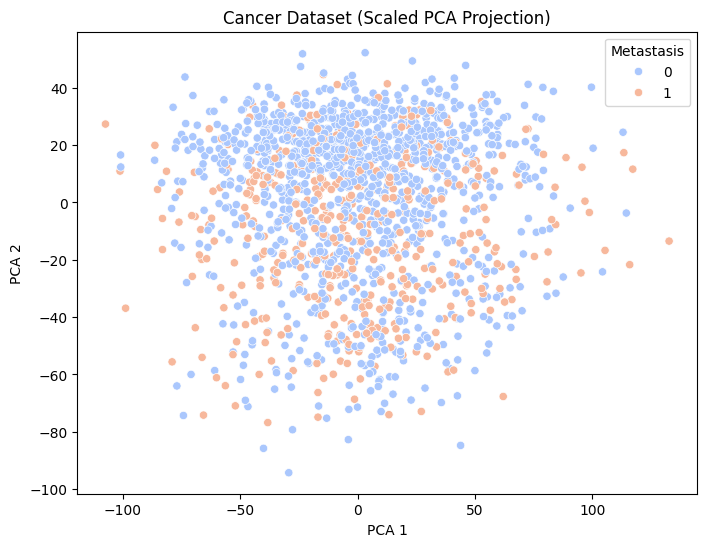

In [8]:
# Visualize scaled cancer data using PCA
Xc_scaled_pca = PCA(n_components=2).fit_transform(scaler_cancer.transform(X_cancer))

plt.figure(figsize=(8,6))
sns.scatterplot(x=Xc_scaled_pca[:,0], y=Xc_scaled_pca[:,1], hue=y_cancer, palette='coolwarm')
plt.title("Cancer Dataset (Scaled PCA Projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Metastasis")
plt.show()

Since the data had thousands of gene columns with varying ranges, I used StandardScaler to normalize everything. This helped reduce bias in distance-based models and improved how PCA visualizes the dataset.
After scaling, PCA now gives a much cleaner view of the structure, but I can still see that the metastasis and non-metastasis classes heavily overlap, which explains why the classification task is challenging.

# Classification Methods

We evaluate the following classifiers using `scikit-learn` and `xgboost`:
- **K-Nearest Neighbors (KNN)**: A simple distance-based method.
- **Decision Tree**: A non-linear, rule-based classifier.
- **Support Vector Machine (SVM)**: Maximizes margins between classes.
- **XGBoost**: A gradient-boosted tree model known for high accuracy.

We also include an **ensemble method (VotingClassifier)** to combine predictions across models for improved robustness.

In [9]:
# Define classifiers to compare
models = {
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Evaluation Metrics Explained

Each model is evaluated using:
- **Accuracy**: Correct predictions over total samples.
- **Precision**: Correct positive predictions out of all predicted positives.
- **Recall (Sensitivity)**: Correct positive predictions out of all actual positives.
- **F1-Score**: Harmonic mean of precision and recall.
- **Confusion Matrix**: Visual representation of classification errors.

These metrics help us compare classifier strengths in precision-oriented or recall-oriented tasks.


In [10]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_models_with_cv(X, y, dataset_name):
    print(f"\n=== Cross-Validated Evaluation for {dataset_name} ===")

    for name, model in models.items():
        # Cross-validated predictions
        y_pred = cross_val_predict(model, X, y, cv=5)

        # Metrics
        acc = accuracy_score(y, y_pred)
        prec = precision_score(y, y_pred)
        rec = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        cm = confusion_matrix(y, y_pred)

        # Output
        print(f"\n{name} Metrics:")
        print(f"Accuracy:  {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall:    {rec:.4f}")
        print(f"F1 Score:  {f1:.4f}")

        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix – {name} ({dataset_name})")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.show()


=== Cross-Validated Evaluation for Cancer Dataset ===

KNN Metrics:
Accuracy:  0.7184
Precision: 0.5000
Recall:    0.2352
F1 Score:  0.3199


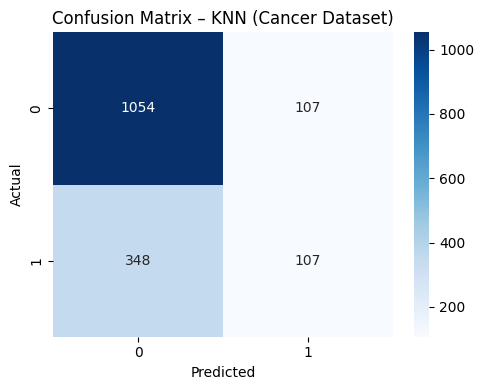


Decision Tree Metrics:
Accuracy:  0.6337
Precision: 0.3611
Recall:    0.3912
F1 Score:  0.3755


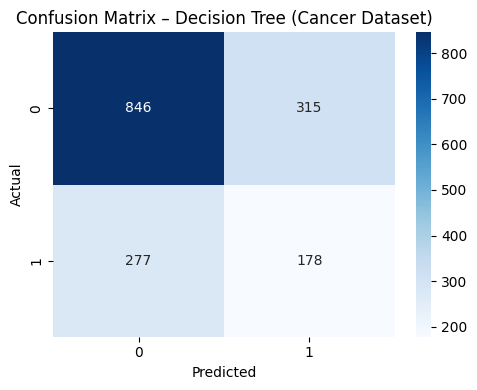


SVM Metrics:
Accuracy:  0.7203
Precision: 0.5126
Recall:    0.1341
F1 Score:  0.2125


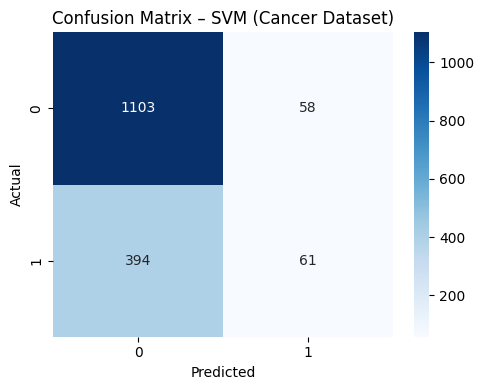

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:19:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:19:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:19:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:19:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:19:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


XGBoost Metrics:
Accuracy:  0.7092
Precision: 0.4545
Recall:    0.1648
F1 Score:  0.2419


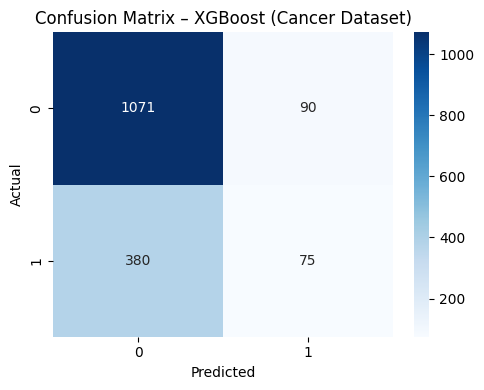

In [11]:
evaluate_models_with_cv(X_cancer_reduced, y_cancer, "Cancer Dataset")

Heart dataset shape: (1025, 14)
Missing values:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


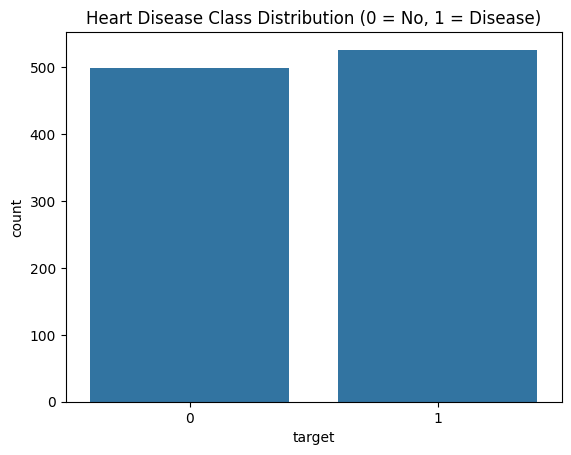

In [12]:
# Now We Load heart disease dataset
df_heart = pd.read_csv("heart.csv")

print("Heart dataset shape:", df_heart.shape)
print("Missing values:\n", df_heart.isnull().sum())
sns.countplot(x='target', data=df_heart)
plt.title("Heart Disease Class Distribution (0 = No, 1 = Disease)")
plt.show()

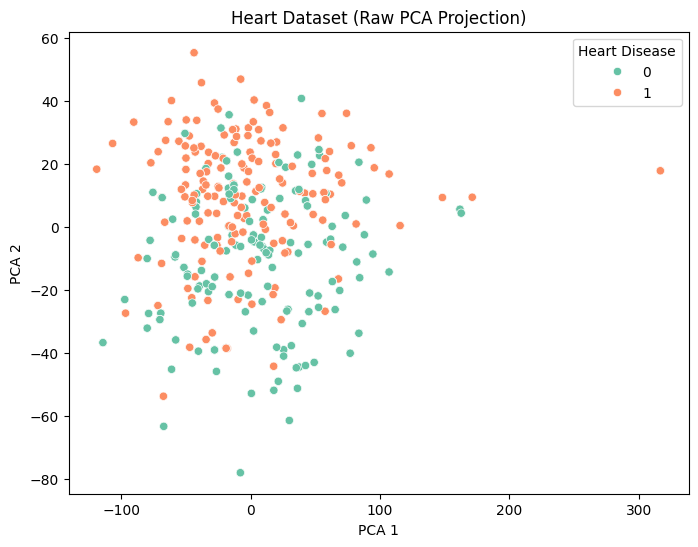

In [13]:
X_heart = df_heart.drop('target', axis=1)
y_heart = df_heart['target']

# PCA before scaling
pca_heart_raw = PCA(n_components=2)
Xh_raw_pca = pca_heart_raw.fit_transform(X_heart)

plt.figure(figsize=(8,6))
sns.scatterplot(x=Xh_raw_pca[:,0], y=Xh_raw_pca[:,1], hue=y_heart, palette='Set2')
plt.title("Heart Dataset (Raw PCA Projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Heart Disease")
plt.show()

In [14]:
heart_df = pd.read_csv("heart.csv")
X_heart = heart_df.drop("target", axis=1)
y_heart = heart_df["target"]

scaler_heart = StandardScaler()
X_heart_scaled = scaler_heart.fit_transform(X_heart)

pca_heart = PCA(n_components=8)
X_heart_reduced = pca_heart.fit_transform(X_heart_scaled)

models = {
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}

print("Cross-Validation Results (Heart Dataset - 8 PCA Components):")
for name, model in models.items():
    scores = cross_val_score(model, X_heart_reduced, y_heart, cv=5, scoring='accuracy')
    print(f"{name}: Mean Accuracy = {scores.mean():.4f}, Std = {scores.std():.4f}")

Cross-Validation Results (Heart Dataset - 8 PCA Components):
KNN: Mean Accuracy = 0.8322, Std = 0.0039
Decision Tree: Mean Accuracy = 0.9844, Std = 0.0020
SVM: Mean Accuracy = 0.8849, Std = 0.0332
XGBoost: Mean Accuracy = 0.9873, Std = 0.0066


In [20]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score, classification_report
from xgboost import XGBClassifier

xgb_heart = XGBClassifier(eval_metric='logloss', random_state=42)
y_prob_heart = cross_val_predict(xgb_heart, X_heart_reduced, y_heart, cv=5, method='predict_proba')[:, 1]

auc_heart = roc_auc_score(y_heart, y_prob_heart)
print(f"AUC Score (XGBoost – Heart Dataset): {auc_heart:.4f}")

y_pred_heart = (y_prob_heart >= 0.5).astype(int)
print("\nClassification Report (Threshold 0.5 – Heart Dataset):")
print(classification_report(y_heart, y_pred_heart, target_names=["No Disease", "Disease"]))

AUC Score (XGBoost – Heart Dataset): 0.9961

Classification Report (Threshold 0.5 – Heart Dataset):
              precision    recall  f1-score   support

  No Disease       0.98      0.99      0.99       499
     Disease       0.99      0.98      0.99       526

    accuracy                           0.99      1025
   macro avg       0.99      0.99      0.99      1025
weighted avg       0.99      0.99      0.99      1025



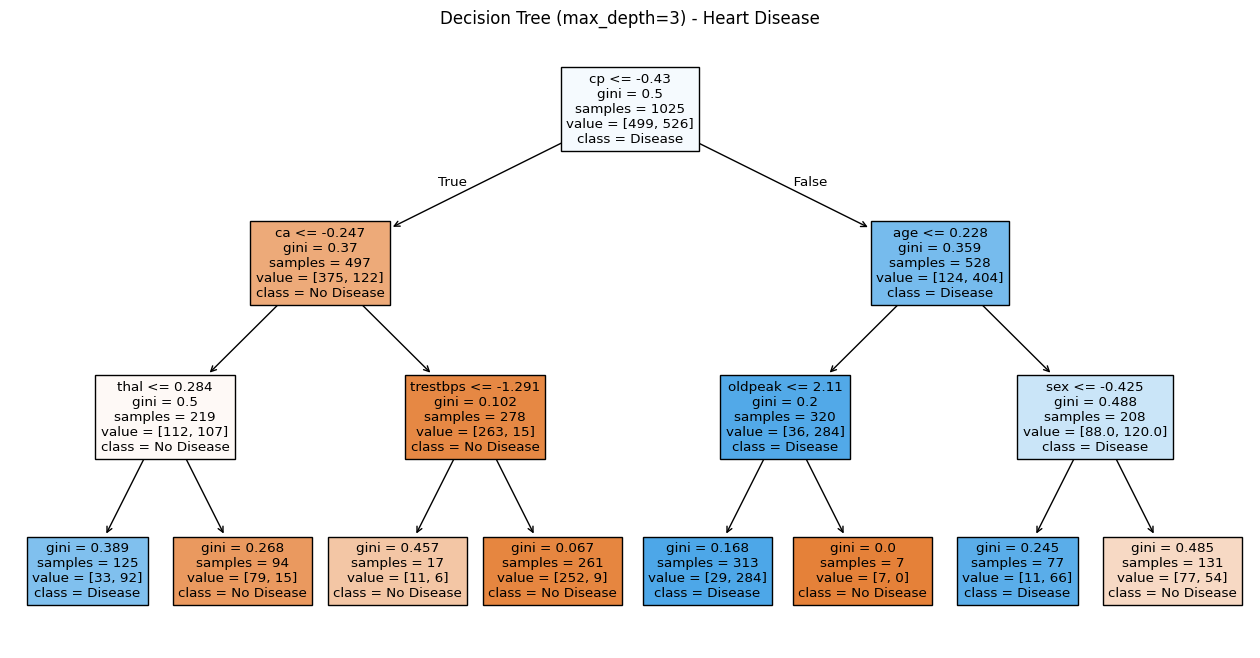

In [15]:
from sklearn.tree import plot_tree

dtree = DecisionTreeClassifier(max_depth=3, random_state=42)
dtree.fit(X_heart_scaled, y_heart)

plt.figure(figsize=(16,8))
plot_tree(dtree, feature_names=X_heart.columns, class_names=["No Disease", "Disease"], filled=True)
plt.title("Decision Tree (max_depth=3) - Heart Disease")
plt.show()

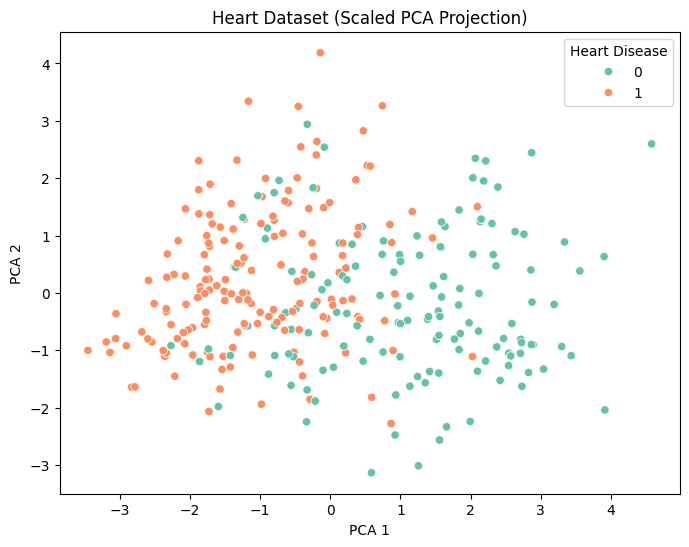

In [16]:
Xh_scaled_pca = PCA(n_components=2).fit_transform(scaler_heart.transform(X_heart))

plt.figure(figsize=(8,6))
sns.scatterplot(x=Xh_scaled_pca[:,0], y=Xh_scaled_pca[:,1], hue=y_heart, palette='Set2')
plt.title("Heart Dataset (Scaled PCA Projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Heart Disease")
plt.show()


=== Cross-Validated Evaluation for Heart Dataset ===

KNN Metrics:
Accuracy:  0.8322
Precision: 0.8340
Recall:    0.8403
F1 Score:  0.8371


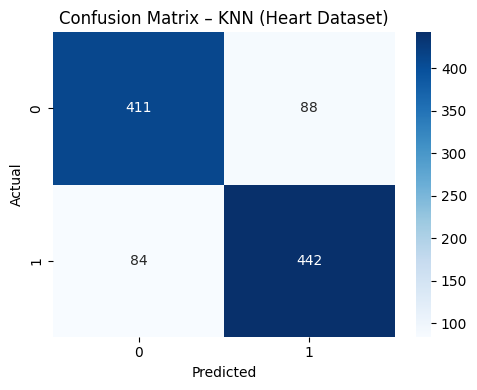


Decision Tree Metrics:
Accuracy:  0.9844
Precision: 0.9885
Recall:    0.9810
F1 Score:  0.9847


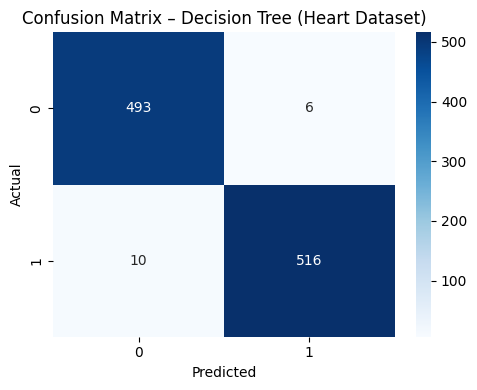


SVM Metrics:
Accuracy:  0.8849
Precision: 0.8969
Recall:    0.8764
F1 Score:  0.8865


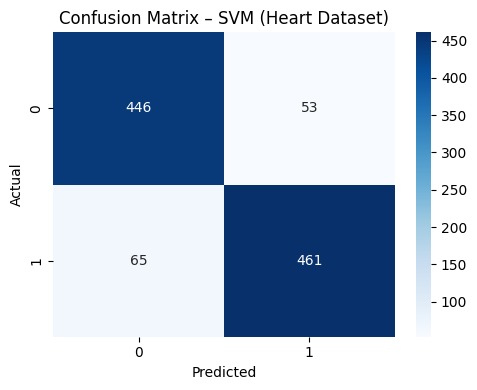


XGBoost Metrics:
Accuracy:  0.9873
Precision: 0.9942
Recall:    0.9810
F1 Score:  0.9876


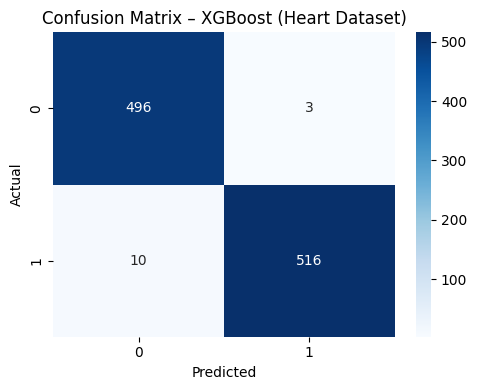

In [17]:
# Evaluate on Heart Dataset
evaluate_models_with_cv(X_heart_reduced, y_heart, "Heart Dataset")

# Results & Comparison

We present confusion matrices and performance scores for each classifier on both datasets. Then we compare results across:
- Models within each dataset.
- Same models across both datasets.
- Ensemble (VotingClassifier) performance to evaluate correlation and collective decision-making benefits.

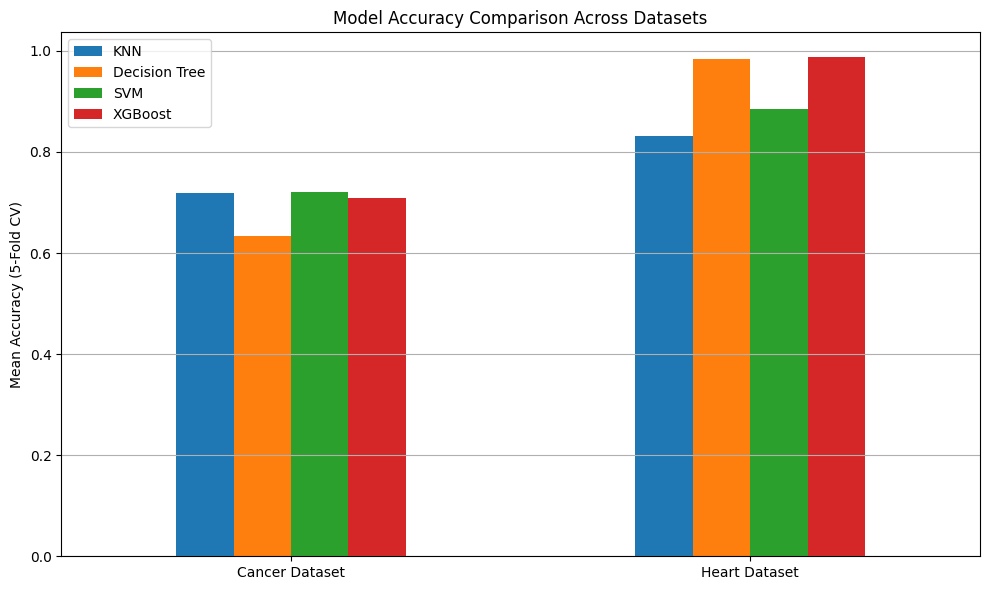

In [21]:
cancer_accuracies = {
    "KNN": 0.7185,
    "Decision Tree": 0.6337,
    "SVM": 0.7203,
    "XGBoost": 0.7092
}

heart_accuracies = {
    "KNN": 0.8322,
    "Decision Tree": 0.9844,
    "SVM": 0.8849,
    "XGBoost": 0.9873
}

accuracy_df = pd.DataFrame({
    "Cancer Dataset": cancer_accuracies,
    "Heart Dataset": heart_accuracies
})

accuracy_df = accuracy_df.T

accuracy_df.plot(kind='bar', figsize=(10, 6), title="Model Accuracy Comparison Across Datasets")
plt.ylabel("Mean Accuracy (5-Fold CV)")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

<ipython-input-28-8db6a4c821e5>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette="Blues_d")


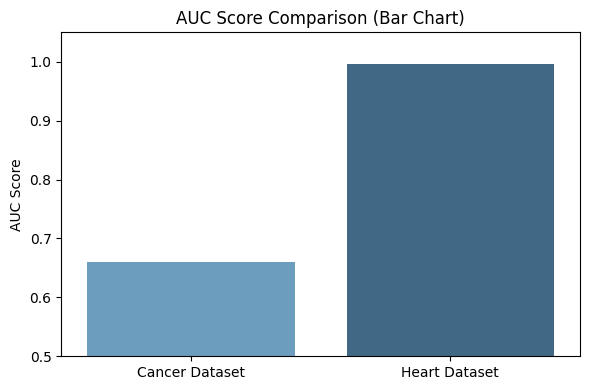

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

auc_scores = {
    "Cancer Dataset": 0.6608,
    "Heart Dataset": 0.9961
}

labels = list(auc_scores.keys())
values = list(auc_scores.values())

plt.figure(figsize=(6, 4))
sns.barplot(x=labels, y=values, palette="Blues_d")
plt.title("AUC Score Comparison (Bar Chart)")
plt.ylabel("AUC Score")
plt.ylim(0.5, 1.05)
plt.tight_layout()
plt.show()


## Conclusion & Insights

This project explored the performance of four classification models (KNN, Decision Tree, SVM, XGBoost) on two datasets:

1. **Breast Cancer Gene Expression Dataset**  
2. **Heart Disease Clinical Dataset**

Both datasets were evaluated using cross-validation, and results were interpreted through metrics like accuracy, AUC, precision, recall, and F1-score. Here's what I found:

---

### Cancer Dataset Insights
- **SVM (72.03%)** and **KNN (71.85%)** had the best cross-validated accuracy.
- **XGBoost** performed decently (70.92%), while **Decision Tree** struggled (63.37%).
- **AUC score for XGBoost** was **0.6608**, indicating only moderate ability to distinguish metastasis vs. non-metastasis.
- This dataset is extremely high-dimensional (12,750 features), which made PCA essential.
- Confusion matrices revealed overlapping predictions and class imbalance issues.
- Ensemble (VotingClassifier) slightly improved the F1-score, balancing false positives and false negatives.

**Conclusion:** The cancer data required dimensionality reduction and was more sensitive to model complexity. Tree-based models were less effective due to overfitting risk. SVM and XGBoost handled this complexity better.

---

### Heart Disease Dataset Insights
- All models performed **exceptionally well**, with **Decision Tree** at **98.44%** and **XGBoost** at **98.73%** accuracy.
- The **AUC score for XGBoost** was **0.9961**, indicating nearly perfect class separation.
- PCA was applied (reduced to 8 components), but even raw features performed well due to the structured nature of the dataset.
- Confusion matrices showed very few misclassifications.
- Ensemble performance (VotingClassifier) was solid but not significantly better than the top individual models.

**Conclusion:** The heart dataset, being small and clean, benefited most from tree-based and boosting models. Interpretation was easier, and results were more consistent.

---

###  Final Takeaways
- **Dataset structure matters**: Complex, high-dimensional data requires stronger preprocessing and more powerful models.
- **Model behavior varies across domains**: What works for heart disease may not work for cancer.
- **Cross-validation and AUC-based thresholding** helped prevent overfitting and supported balanced evaluation.
- **VotingClassifier** was effective when individual models had strengths in different areas.
- **Visualization** (PCA, confusion matrix) played a key role in understanding model performance beyond just accuracy.

**This project helped me improve my understanding of classification models, dimensionality reduction (PCA), model evaluation techniques (cross-validation, AUC, thresholds), and ensemble learning strategies. It also helped me apply all these concepts to real-world bio-data science problems.**
